**TASK-1 BIG DATA ANALYSIS**

Successfully loaded data from /content/googleplaystore.csv
root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Ver: string (nullable = true)
 |-- Android Ver: string (nullable = true)

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+----------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|    Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------

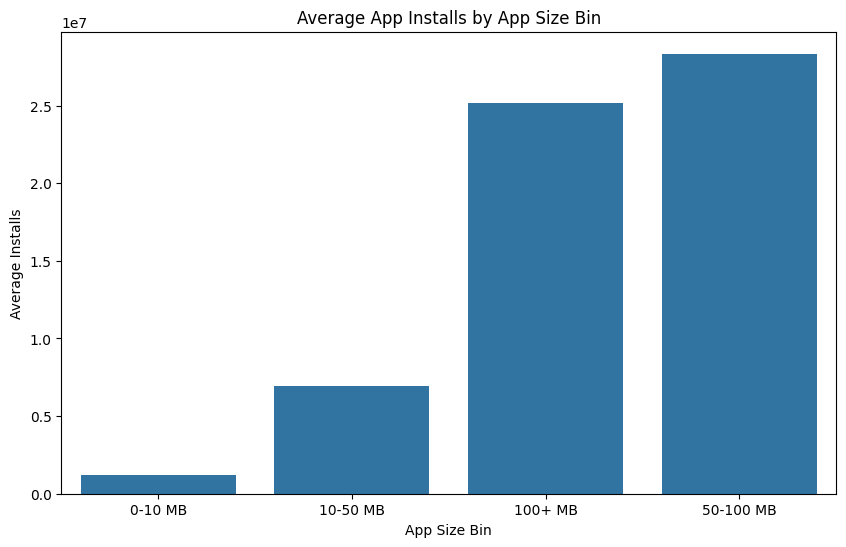


Columns in avg_metrics_by_size_bin_pd:
Index(['Size_Bin', 'Average Installs', 'Average Size (MB)', 'App Count'], dtype='object')


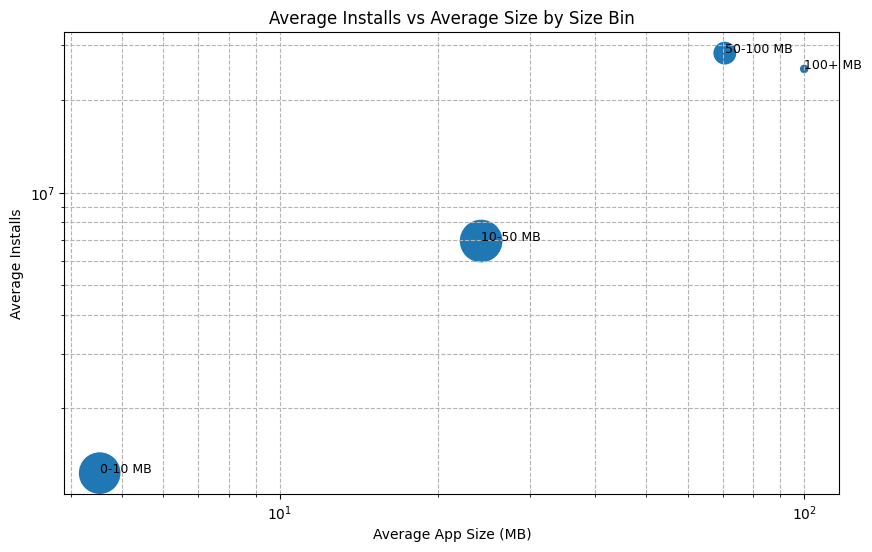


Spark session stopped.


In [1]:
# Install required libraries
!pip install pyspark pandas --quiet

# --- IMPORTS ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, when, lit, count, avg
from pyspark.sql.types import FloatType
import pandas as pd
import re # Need this for parsing size string

# --- SPARK SESSION ---
spark = SparkSession.builder.appName("GooglePlayAnalysisSizeInstalls").getOrCreate()

# --- LOAD DATA ---
# Using the correct path for the dataset
csv_file_path = "/content/googleplaystore.csv"
try:
    df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
    print(f"Successfully loaded data from {csv_file_path}")
    df.printSchema()
    df.show(5)
except Exception as e:
    print(f"Error loading data from {csv_file_path}: {e}")
    # Exit if data loading fails
    spark.stop()
    exit()

# --- DATA CLEANING for Size and Installs ---

# Remove rows with nulls in important columns needed for this analysis
initial_row_count = df.count()
df_clean = df.dropna(subset=['Size', 'Installs', 'Category'])
rows_after_dropna = df_clean.count()
print(f"\nRemoved {initial_row_count - rows_after_dropna} rows with nulls in 'Size', 'Installs', or 'Category'.")

# Clean 'Installs' column (remove '+' and ',' and convert to integer)
# Handle the case where the column might already be numeric from inferSchema
if 'Installs' in df_clean.columns and not isinstance(df_clean.schema['Installs'].dataType, (FloatType, int)):
     df_clean = df_clean.withColumn('Installs_clean', regexp_replace(col('Installs'), '[+,]', ''))
     df_clean = df_clean.withColumn('Installs_clean', col('Installs_clean').cast('int'))
else:
     print("\n'Installs' column already appears numeric or could not be found, skipping regex and cast.")
     df_clean = df_clean.withColumn('Installs_clean', col('Installs').cast('int')) # Still attempt cast

# Handle 'Size' column:
# Convert 'M' and 'k' to Bytes and then to MB (or just parse directly to MB)
# Handle 'Varies with device'
# Use UDF or series of PySpark functions for complex parsing

# Let's define a function to parse size strings and convert to MB
# This is easier to implement in a Python function, but running it row-wise in PySpark is inefficient.
# A better way is to use PySpark string functions.

# Clean 'Size' column using PySpark string functions
df_clean = df_clean.withColumn('Size_clean_str', regexp_replace(col('Size'), ',', '')) # Remove commas if any

# Convert size to MB (approximately)
# 'M' -> multiply by 1
# 'k' -> divide by 1024
# 'Varies with device' -> Null (or some indicator)
df_clean = df_clean.withColumn('Size_MB',
    when(col('Size_clean_str').endswith('M'),
         regexp_replace(col('Size_clean_str'), 'M', '').cast(FloatType()))
    .when(col('Size_clean_str').endswith('k'),
          regexp_replace(col('Size_clean_str'), 'k', '').cast(FloatType()) / 1024)
    .otherwise(lit(None).cast(FloatType())) # Set 'Varies with device' and other values to None/Null
)

# Drop original 'Size' and the intermediate 'Size_clean_str' column
df_clean = df_clean.drop('Size', 'Size_clean_str')

# Drop original 'Installs' if Installs_clean was created
if 'Installs_clean' in df_clean.columns and 'Installs' in df_clean.columns and df_clean.schema['Installs_clean'].dataType != df_clean.schema['Installs'].dataType:
     df_clean = df_clean.drop('Installs')

# Remove rows where Installs_clean or Size_MB could not be parsed to numeric (will be null)
rows_before_numeric_dropna = df_clean.count()
df_clean = df_clean.dropna(subset=['Installs_clean', 'Size_MB'])
rows_after_numeric_dropna = df_clean.count()
print(f"\nRemoved {rows_before_numeric_dropna - rows_after_numeric_dropna} rows where 'Installs' or 'Size' could not be converted to numeric.")

print("\nCleaned DataFrame schema and first 5 rows:")
df_clean.printSchema()
df_clean.show(5)

# --- ANALYSIS: Relationship between Size and Installs ---

# Calculate average installs for different size bins (optional, but good for visualization)
# Let's create simple size bins
df_clean = df_clean.withColumn("Size_Bin",
    when(col("Size_MB") < 10, lit("0-10 MB"))
    .when((col("Size_MB") >= 10) & (col("Size_MB") < 50), lit("10-50 MB"))
    .when((col("Size_MB") >= 50) & (col("Size_MB") < 100), lit("50-100 MB"))
    .when(col("Size_MB") >= 100, lit("100+ MB"))
    .otherwise(lit("Unknown")) # Should not happen after dropping nulls, but good practice
)

# Group by size bin and calculate average installs
avg_installs_by_size_bin = df_clean.groupBy("Size_Bin") \
                                    .agg(avg("Installs_clean").alias("Average Installs"),
                                         count("Size_MB").alias("App Count")) \
                                    .orderBy("Size_Bin") # Ordering alphabetically by bin name

print("\nAverage Installs by Size Bin:")
avg_installs_by_size_bin.show()

# Calculate overall correlation between Size and Installs (requires numerical columns)
# Note: Pearson correlation in Spark SQL only works on numeric types.
# Ensure Size_MB and Installs_clean are correctly casted (which we did above).
try:
    correlation = df_clean.stat.corr("Size_MB", "Installs_clean")
    print(f"\nOverall Pearson Correlation between App Size (MB) and Installs: {correlation:.4f}")
except Exception as e:
    print(f"\nCould not calculate correlation: {e}")
    print("Ensure 'Size_MB' and 'Installs_clean' are numeric columns.")


# --- Convert results to Pandas for display/visualization ---
# We'll only convert the aggregated result to Pandas as it's smaller
avg_installs_by_size_bin_pd = avg_installs_by_size_bin.toPandas()

print("\nAverage Installs by Size Bin (Pandas DataFrame):")
print(avg_installs_by_size_bin_pd)


# --- Optional: Visualize the results (using Plotly) ---
# You can integrate this into a Dash app like before if desired,
# but for a simple script output, a static plot is fine.

try:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Plot the average installs by size bin
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Size_Bin', y='Average Installs', data=avg_installs_by_size_bin_pd)
    plt.title('Average App Installs by App Size Bin')
    plt.xlabel('App Size Bin')
    plt.ylabel('Average Installs')
    plt.show()

    # Scatter plot might be too large, but we can plot average size vs average installs if aggregated
    # Let's calculate average size AND count per bin for a scatter plot
    avg_metrics_by_size_bin = df_clean.groupBy("Size_Bin") \
                                      .agg(avg("Installs_clean").alias("Average Installs"),
                                           avg("Size_MB").alias("Average Size (MB)"),
                                           count("Size_MB").alias("App Count")) \
                                      .orderBy("Size_Bin")

    avg_metrics_by_size_bin_pd = avg_metrics_by_size_bin.toPandas()

    # Print column names of the Pandas DataFrame before plotting
    print("\nColumns in avg_metrics_by_size_bin_pd:")
    print(avg_metrics_by_size_bin_pd.columns)

    plt.figure(figsize=(10, 6))
    # Now 'App Count' exists in avg_metrics_by_size_bin_pd
    sns.scatterplot(x='Average Size (MB)', y='Average Installs', size='App Count', sizes=(50, 1000), data=avg_metrics_by_size_bin_pd, legend=False)
    # Add labels for each point
    for i in range(len(avg_metrics_by_size_bin_pd)):
        plt.text(avg_metrics_by_size_bin_pd['Average Size (MB)'][i], avg_metrics_by_size_bin_pd['Average Installs'][i],
                 avg_metrics_by_size_bin_pd['Size_Bin'][i], fontsize=9)
    plt.title('Average Installs vs Average Size by Size Bin')
    plt.xlabel('Average App Size (MB)')
    plt.ylabel('Average Installs')
    plt.xscale('log') # Use log scale for size if there's a wide range
    plt.yscale('log') # Use log scale for installs if there's a wide range
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()


except ImportError:
    print("\nMatplotlib or Seaborn not installed. Skipping plotting.")
    print("Install them with: !pip install matplotlib seaborn")


# --- Stop Spark Session ---
spark.stop()
print("\nSpark session stopped.")